# Neural Networks
A neural network basically is multiple layers of logistic regressions although different **activations** are used (Only sigmoid activation is used in logistic regression). The first layer is called **input layer**. The number of input units are equal to the number of features. The last layer is called **output layer**. The number of output unit depends on the problems. In binary classification, we only need one output (a number between 0 and 1). In multiclass classification, we will use softmax activation. In between, the layers are called **hidden layer**. The structure of a neural network depends on how many hidden layers and how many units in each layer you choose.

<img src="nn_illustration.png" width="300" />

## Problem Setup
In this notebook, we will build a simple neural network with one hidden layer for a binary classification problem. In this case, we have two input units and one output unit because it is binary and we will use sigmoid activation for the output. For the hidden layer, we will use relu activation. We will try different numbers of hidden units.

In [71]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.datasets import make_moons

sns.set()
sns.set_style('white')

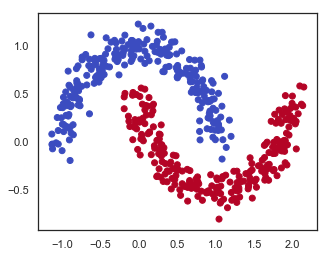

In [72]:
x_train,y_train = make_moons(n_samples=500,noise=0.1,random_state=0)
y_train = np.reshape(y_train,(500,1))

plt.figure(figsize=(5,4))
plt.scatter(x_train[:,0],x_train[:,1],c=y_train.flatten(),cmap=plt.cm.coolwarm)
plt.show()

In [73]:
n_vec = 100
x1_vec = np.linspace(np.min(x_train[:,0])-0.2,np.max(x_train[:,0])+0.2,n_vec)
x2_vec = np.linspace(np.min(x_train[:,1])-0.2,np.max(x_train[:,1])+0.2,n_vec)

x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec)
x_grid = np.vstack((x1_grid.flatten(),x2_grid.flatten())).T

### Coding from scratch

**Initialization**

In [74]:
def initialize_parameters(n_hidden_units, verbose=False, random_state=None):
        
    np.random.seed(random_state)
    
    parameters = {}
    
    parameters['w1'] = np.random.randn(2,n_hidden_units)
    parameters['b1'] = np.zeros((1,n_hidden_units))
    parameters['w2'] = np.random.randn(n_hidden_units,1)
    parameters['b2'] = np.zeros((1,1))
    
    if verbose:
        print("w1: {}, b1: {}".format(parameters['w1'].shape,parameters['b1'].shape))
        print("w2: {}, b2: {}".format(parameters['w2'].shape,parameters['b2'].shape))
    return parameters  

parameters = initialize_parameters(5, verbose=True)

w1: (2, 5), b1: (1, 5)
w2: (5, 1), b2: (1, 1)


**Forward propagation**

In [75]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

def relu(z):
    g = np.maximum(z,0)
    return g

def foward_probagation(x,parameters,verbose=False):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    a0 = x
    
    z1 = np.dot(a0,w1) + b1
    a1 = relu(z1)
    
    z2 = np.dot(a1,w2) + b2
    a2 = sigmoid(z2)
    
    if verbose:
        print("a0: {}".format(a0.shape))
        print("z1: {}, a1: {}".format(z1.shape,a1.shape))
        print("z2: {}, a2: {}".format(z2.shape,a2.shape))
        
    caches = {}
    caches['a0'] = a0
    caches['z1'] = z1
    caches['a1'] = a1
    caches['z2'] = z2
    caches['a2'] = a2
        
    return caches

caches = foward_probagation(x_train,parameters,verbose=True)

a0: (500, 2)
z1: (500, 5), a1: (500, 5)
z2: (500, 1), a2: (500, 1)


**Backward Propagation**

The cost function $L = -\frac{1}{m}\sum_1^m (y log(a) + (1-y) log(1-a))$, where m is the number of training samples, y is the label, a is the prediction obtained from the forward probagation.

To use the gradient descent, we calculate the derivatives $\frac{dL}{dw}$ and $\frac{dL}{db}$. Recall that $a = \sigma (z)$ and $z = w^T x + b$. When using sigmoid function as the activation, the derivative is,

$\frac{dL}{dw} = \frac{dL}{da} \frac{da}{dz}\frac{dz}{dw} = (a-y)x$

$\frac{dL}{db} = \frac{dL}{da} \frac{da}{dz}\frac{dz}{db} = a-y $



#### One hidden layer

Now let us consider a neural network has one hidden layer. We name the activation of the hidden layer to be $a_1$ and the activation of the output layer to be $a_2$. The parameters and intercepts of the corresponding layers are $w_1,b_1,w_2,b_2$.

In terms of the backward propagation from the output to the hidden layer, we can regard the hidden layer as the feature. Hence, we can write the formula based on the single logistic regression,

$\frac{dL}{dw_2} = (a_2-y)a_1$

$\frac{dL}{db_2} = a_2-y$

Based on these, we can do more backward propagation to calculate the derivatives of the $w_1$ and $b_1$,

$\frac{dL}{dw_1} = \frac{dL}{a_2} \frac{da_2}{dz_1} \frac{dz_1}{da_1} \frac{dz_1}{dw_1}$

$\frac{dL}{db_1} = \frac{dL}{a_2} \frac{da_2}{dz_1} \frac{dz_1}{da_1} \frac{dz_1}{db_1}$

We can easily write out $\frac{dL}{dw_1}$ if the activation function of the hidden layer is the sigmoid/logistic function, but usually we will not use it for the hidden layers. Instead, people use **tanh** or **ReLU** functions, which have the advantages on fastening the learning speed or better distributing the output for the next layer. Therefore, a more general formula will be,

$\frac{dL}{dw_1} = (a_2-y) w_2 g_1^{'}(z_1)x $

$\frac{dL}{db_1} = (a_2-y) w_2 g_1^{'}(z_1) $

where $g_1^{'}$ is the derivative of the activation function. Different choices of activation function will give different derivatives.

In [76]:
def sigmoid_derivative(a):
    dz = a*(1-a)
    return dz

def relu_derivative(a):
    dz = np.float32(a>0)
    return dz

def backward_probagation(y,parameters,caches,verbose=False):
    
    m = y.shape[0]
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    
    a0 = caches['a0']
    z1 = caches['z1']
    a1 = caches['a1'] 
    z2 = caches['z2']
    a2 = caches['a2']
    
    grads = {}
    cost = -np.mean(y*np.log(a2) + (1-y)*np.log(1-a2))
        
    # sigmoid backward
    da2 = -y/a2 + (1-y)/(1-a2) 
    dz2 = da2*sigmoid_derivative(a2)  
    dw2 = np.dot(a1.T,dz2)/m  
    db2 = np.mean(dz2,axis=0,keepdims=True)
        
    grads['dw2'] = dw2
    grads['db2'] = db2
    
    # relu backward
    da1 = np.dot(dz2,w2.T)
    dz1 = da1*relu_derivative(a1)  
    dw1 = np.dot(a0.T,dz1)/m
    db1 = np.mean(dz1,axis=0,keepdims=True)
        
    grads['dw1'] = dw1
    grads['db1'] = db1
    
    if verbose:
        print("cost: {}".format(cost))
        print("da2: {}, dz2: {}".format(da2.shape,dz2.shape))
        print("dw2: {}, db2: {}".format(dw2.shape,db2.shape))
        print("da1: {}, dz1: {}".format(da1.shape,dz1.shape))
        print("dw1: {}, db1: {}".format(dw1.shape,db1.shape))
                  
    return grads, cost

def update_parameters(parameters,grads,learning_rate):
    
    parameters['w1'] = parameters['w1'] - learning_rate*grads['dw1']
    parameters['b1'] = parameters['b1'] - learning_rate*grads['db1']
    parameters['w2'] = parameters['w2'] - learning_rate*grads['dw2']
    parameters['b2'] = parameters['b2'] - learning_rate*grads['db2']
                
    return parameters


grads, cost = backward_probagation(y_train,parameters,caches,verbose=True)
parameters = update_parameters(parameters,grads,0.01)

cost: 0.43338552656429774
da2: (500, 1), dz2: (500, 1)
dw2: (5, 1), db2: (1, 1)
da1: (500, 5), dz1: (500, 5)
dw1: (2, 5), db1: (1, 5)


**Put them together**

In [89]:
def nn_predict(x,parameters):
    caches = foward_probagation(x,parameters)
    a2 = caches['a2']
    y = np.float32(a2>0.5)
    
    return y

def nn_fit(x,y,n_hidden_units,learning_rate,num_iterations=2500,print_cost=True):
    
    parameters = initialize_parameters(n_hidden_units,random_state=1)
    
    for i in range(num_iterations+1):
        caches = foward_probagation(x,parameters)
        grads,cost = backward_probagation(y,parameters,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
    
        if print_cost and i % 500 == 0:
            y_pred = nn_predict(x,parameters)
            accuracy = np.mean(y_pred==y)
    
            print("Cost after iteration %d = %.4f, accuracy = %.4f" % (i, cost, accuracy))
            
    return parameters

parameters = nn_fit(x_train,y_train,100,learning_rate=0.1,num_iterations=2500,print_cost=True)

Cost after iteration 0 = 6.4308, accuracy = 0.2500
Cost after iteration 500 = 0.0606, accuracy = 0.9900
Cost after iteration 1000 = 0.0306, accuracy = 0.9940
Cost after iteration 1500 = 0.0200, accuracy = 0.9960
Cost after iteration 2000 = 0.0148, accuracy = 0.9980
Cost after iteration 2500 = 0.0119, accuracy = 0.9980


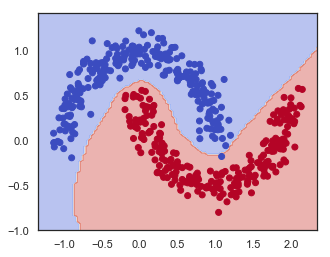

In [90]:
y_grid = nn_predict(x_grid,parameters).reshape(x1_grid.shape)
    
plt.figure(figsize=(5,4))
plt.contourf(x1_grid, x2_grid, y_grid,cmap=plt.cm.coolwarm,alpha=0.4)
plt.scatter(x_train[:,0],x_train[:,1],c=y_train.flatten(),cmap=plt.cm.coolwarm)
plt.show()

**Test different number of hidden layer**

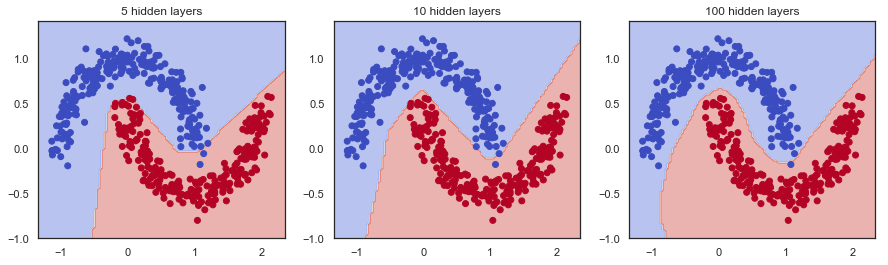

In [92]:
plt.figure(figsize=(15,4))
n_hu_vec = [5,10,100]
for i in range(3):
    parameters = nn_fit(x_train,y_train,n_hu_vec[i],learning_rate=0.1,num_iterations=2500,print_cost=False)
    y_grid = nn_predict(x_grid,parameters).reshape(x1_grid.shape)
    
    plt.subplot(1,3,i+1)
    plt.contourf(x1_grid, x2_grid, y_grid,cmap=plt.cm.coolwarm,alpha=0.4)
    plt.scatter(x_train[:,0],x_train[:,1],c=y_train.flatten(),cmap=plt.cm.coolwarm)
    plt.title("{} hidden layers".format(n_hu_vec[i]))
plt.show()

### Tensorflow framework

Cost after iteration 0 = 4.5517, accuracy = 0.8060
Cost after iteration 500 = 0.0053, accuracy = 1.0000
Cost after iteration 1000 = 0.0029, accuracy = 1.0000
Cost after iteration 1500 = 0.0020, accuracy = 1.0000
Cost after iteration 2000 = 0.0015, accuracy = 1.0000
Cost after iteration 2500 = 0.0012, accuracy = 1.0000


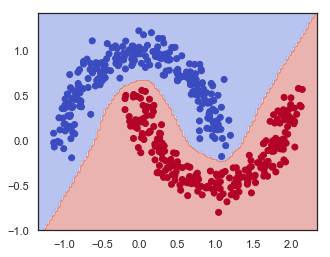

In [93]:
#
#
def tf_nn_fit(x_input,y_input,n_h,learning_rate,num_iterations=2500,print_cost=False):
    tf.reset_default_graph()
    tf.set_random_seed(1) 

    x = tf.placeholder(tf.float32,shape=(None,2),name='x')
    y = tf.placeholder(tf.float32,shape=(None,1),name='y')

    # initialize parameters
    w1 = tf.get_variable('w1',(2,n_h),initializer=tf.random_normal_initializer(stddev=1))
    # note: stddev of random_normal_initializer matters the final results
    # strategy: not to small (close to zeros, which not easy to break the symatric
    #           not too large, which slow the GD and easy to diverge
    b1 = tf.get_variable('b1',(1,n_h),initializer=tf.zeros_initializer())
    w2 = tf.get_variable('w2',(n_h,1),initializer=tf.random_normal_initializer(stddev=1))
    b2 = tf.get_variable('b2',(1,1),initializer=tf.zeros_initializer())


    z1 = tf.matmul(x,w1) + b1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(a1,w2) + b2
    a2 = tf.nn.sigmoid(z2)
    
    y_pred = tf.cast(tf.greater(a2,0.5),tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred,tf.cast(y,tf.int32)),tf.float32))
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=z2,labels=y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)

        for i in range(0,num_iterations+1):
            _,cost_value = sess.run([optimizer,cost], feed_dict={x: x_input, y: y_input})
            accuracy_value = sess.run(accuracy, feed_dict={x: x_input, y: y_input})
            if print_cost and i % 500 == 0:
                print("Cost after iteration %d = %.4f, accuracy = %.4f" % (i, cost_value, accuracy_value))

        y_grid = sess.run(a2,feed_dict={x: x_grid})
        y_grid = np.float32(y_grid>0.5).reshape(x1_grid.shape)
        
    return y_grid

y_grid = tf_nn_fit(x_train,y_train,100,learning_rate=1,num_iterations=2500,print_cost=True)
plt.figure(figsize=(5,4))
plt.contourf(x1_grid, x2_grid, y_grid,cmap=plt.cm.coolwarm,alpha=0.4)
plt.scatter(x_train[:,0],x_train[:,1],c=y_train.flatten(),cmap=plt.cm.coolwarm)
plt.show()

### Keras framework

In [81]:
from keras.initializers import random_normal
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [82]:
model = Sequential()
model.add(Dense(100,input_dim=2,kernel_initializer=random_normal(stddev=1)))
model.add(Activation('relu'))
model.add(Dense(1,kernel_initializer=random_normal(stddev=1)))
model.add(Activation('sigmoid'))        
model.compile(optimizer=optimizers.sgd(lr=1),loss='binary_crossentropy',metrics=['binary_accuracy'])
model.summary()
model.fit(x_train, y_train, epochs=5, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
500/500 [==============================] - 1s 2ms/step - loss: 0.0038 - binary_accuracy: 1.0000
Epoch 2/5
500/500 [==============================] - 0s 104us/step - loss: 0.0038 - binary_accuracy: 1.0000
Epoch 3/5
500/500 [==============================] - 0s 135us/

In [83]:
model.evaluate(x_train,y_train)

500/500 [==============================] - 0s 426us/step


[0.0032412427216768265, 1.0]

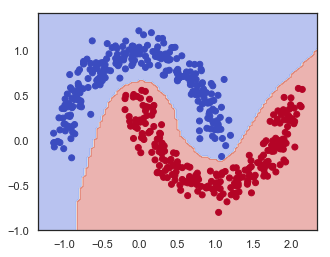

In [84]:
y_grid = model.predict(x_grid)
y_grid = np.reshape(np.float32(y_grid>0.5),x1_grid.shape)
plt.figure(figsize=(5,4))
plt.contourf(x1_grid, x2_grid, y_grid,cmap=plt.cm.coolwarm,alpha=0.4)
plt.scatter(x_train[:,0],x_train[:,1],c=y_train.flatten(),cmap=plt.cm.coolwarm)
plt.show()

## Conclusion

We have implemented our own codes (initialization, forward propagation and backward propagation) to build a simple neural network! This is a good practice and way to learn neural networks. However, nowadays, there are some programming frameworks for neural networks that we do not have to worry about backward propagation which is the most challenging part. Here, we do the same thing using tensorflow and keras framework. 

P.S. This notebook is one example of how I study the machine and deep learning methods. More examples are in my github (https://github.com/jeremy-xx).